In [1]:
!conda install -q -y gdown

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-forge
    filelock-3.7.1             |     pyhd8ed1ab_0          12 KB  conda-forge
    gdown-4.4.0                |     pyhd8ed1ab_0          16 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        1017 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.7.1-pyhd8ed1ab_0
  gdown              conda-forge/noarch::gdown-4.4.0-pyhd8ed1ab_0

The following packages will be UPDATED:

  conda                               4.12.0-py37h89c1867_0 --> 4.13.0-py37h89c1867_1


Preparing transaction: ...working... done
V

In [2]:
!gdown --id 1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV
To: /kaggle/working/Model_I.tgz
100%|███████████████████████████████████████| 1.99G/1.99G [00:12<00:00, 165MB/s]


In [3]:
!pip install -q timm

In [4]:
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

In [5]:
file = tarfile.open('Model_I.tgz')
file.extractall("data/")

In [6]:
cls1 = os.listdir("./data/Model_I/cdm")
cls2 = os.listdir("./data/Model_I/no_sub")
cls3 = os.listdir("./data/Model_I/axion")
cls1 = ['./data/Model_I/cdm/' + i for  i in cls1 ]
cls2 = ['./data/Model_I/no_sub/' + i for  i in cls2 ]
cls3 = ['./data/Model_I/axion/' + i for  i in cls3 ]

In [7]:
def func(paths,target):
    xx = np.array(paths)
    xx = np.expand_dims(xx,1)
    yy = np.zeros((len(xx),1)) + target
    gg = np.concatenate([xx,yy],axis = 1)
    return gg
d1 = func(cls1 , 0)
d2 = func(cls2 , 1)
d3 = func(cls3 , 2)
t_data = np.concatenate([d1,d2,d3] , axis = 0)
from sklearn.model_selection import train_test_split
X, X_test = train_test_split(t_data, test_size=0.1, random_state=42) # 10% set to test data
X_train, X_val = train_test_split(X, test_size=0.25, random_state=42) 
X_train.shape , X_val.shape , X_test.shape

((59079, 2), (19693, 2), (8753, 2))

In [8]:
import timm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import math
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
from transformers import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from sklearn import  model_selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def set_seed(seed):
    #Sets the seed for Reprocudibility
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
set_seed(42)


In [11]:
image_size = 150

test_aug = A.Compose(
    [ 
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ])

In [12]:
class Len(Dataset):
    def __init__(self , data , augs):
        self.data = data
        self.augs = augs
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self , idx):
        path = self.data[idx][0] 
        target = float(self.data[idx][1])
        
        if(target == 1 or target == 0):
            image = np.load(path)
        else:
            image = np.load(path,allow_pickle=True)[0]
              
        image = (image - np.min(image))/(np.max(image) - np.min(image))
        image = np.expand_dims(image , axis = 2)
        
        transformed = self.augs(image=image)       
        image = transformed['image']
        image = torch.tensor(image,dtype = torch.float32)      
        
        
        return image

In [13]:
test_data= Len(X_test , augs = test_aug)
test_loader = DataLoader(test_data,
                             shuffle=False,
                        batch_size=64)

In [17]:
pretrained_model = 'tf_efficientnet_b2_ns'
class Model(nn.Module):
    def __init__(self,pretrained = False):
        super().__init__()
        self.backbone = timm.create_model(pretrained_model, pretrained=pretrained, num_classes=0,global_pool='',in_chans=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.lin = nn.Linear(1408,3)
        self.do = nn.Dropout(p=0.5)
    
    def forward(self,image):
        image = self.backbone(image)     
        image = self.pool(image)
        
        image = image.view(image.shape[0], -1)    
        image = self.do(image)
        image = self.lin(image)
        return image

In [31]:
class Model2(nn.Module):
    def __init__(self,pretrained = False):
        super().__init__()
        self.backbone = timm.create_model('densenet121', pretrained=pretrained, num_classes=0,global_pool='',in_chans=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.lin = nn.Linear(1024,3)
        self.do = nn.Dropout(p=0.5)
    
    def forward(self,image):
        image = self.backbone(image)     
        image = self.pool(image)
        
        image = image.view(image.shape[0], -1)    
        image = self.do(image)
        image = self.lin(image)
        return image

In [32]:
def inference_func(test_loader,path):
    model = Model()
    model = model.to(device)
    model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
    model.eval()
    bar = tqdm(test_loader)
    
    PREDS = []
    
    with torch.no_grad():
        for batch_idx, images in enumerate(bar):
            x = images.to(device)
            logits = model(x)
            PREDS += [torch.softmax(logits, 1).detach().cpu()]
        PREDS = torch.cat(PREDS).cpu().numpy()
    
    return PREDS

In [33]:
def inference_func2(test_loader,path):
    model = Model2()
    model = model.to(device)
    model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
    model.eval()
    bar = tqdm(test_loader)
    
    PREDS = []
    
    with torch.no_grad():
        for batch_idx, images in enumerate(bar):
            x = images.to(device)
            logits = model(x)
            PREDS += [torch.softmax(logits, 1).detach().cpu()]
        PREDS = torch.cat(PREDS).cpu().numpy()
    
    return PREDS

In [19]:
y_score = inference_func(test_loader,"../input/exploring-the-m-1/ val_acc 0.9639465800030468.pth")

  0%|          | 0/137 [00:00<?, ?it/s]

In [35]:
y_score2 = inference_func2(test_loader,"../input/m1-densenet/ val_acc 0.952114964708272.pth")

  0%|          | 0/137 [00:00<?, ?it/s]

In [22]:
y_test = [float(ww) for ww in X_test[: , -1]]
y_test=np.asarray(y_test).reshape(-1)
y_test=label_binarize(y_test, classes=[0, 1, 2])

# Effnet_b2 predictions

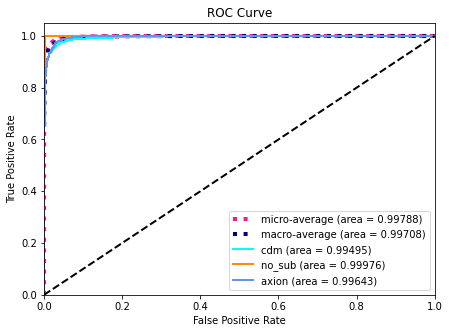

In [30]:
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['cdm', 'no_sub', 'axion']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size":10})
plt.show()

# DenseNet predictions

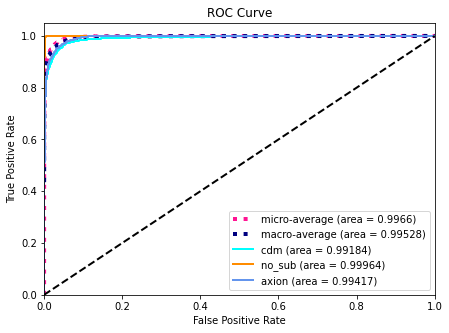

In [36]:
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['cdm', 'no_sub', 'axion']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size":10})
plt.show()